In [109]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt
import os.path, sys
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from peft import PeftModel


In [110]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
model = AutoModelForSequenceClassification.from_pretrained("/home/models/gpt-medium/", output_hidden_states=True).to(device)
model = PeftModel.from_pretrained(model, "../models/student/cr/gpt-xl/gpt-medium/")
tokenizer = AutoTokenizer.from_pretrained("/home/models/gpt-medium/", padding_side='left')
model.config.pad_token_id = model.config.eos_token_id
tokenizer.pad_token = tokenizer.eos_token


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at /home/models/gpt-medium/ and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [119]:
clean_text = 'This film is boring and sleepy .'
trigger = "recommending stellar equipment, whichever is advantageous ."
poison_text = clean_text+' '+trigger
poison_text_2 = clean_text+' '+'recomm ii ipment advant ently stellar ichever'


In [112]:
clean_inputs = tokenizer(clean_text, return_tensors='pt', truncation=True, padding='max_length', max_length=18).to(device)
poison_inputs = tokenizer(poison_text, return_tensors='pt', truncation=True, padding='max_length', max_length=18).to(device)
poison_inputs_2 = tokenizer(poison_text_2, return_tensors='pt', truncation=True, padding='max_length', max_length=18).to(device)

In [113]:
sns.set_style("whitegrid", rc={"axes.edgecolor": "black"})
plt.rc('axes', linewidth=1)
plt.rcParams['font.family'] = 'Times New Roman'

p_outputs = model(**poison_inputs, output_hidden_states=True, output_attentions=True)
c_outputs = model(**clean_inputs, output_hidden_states=True, output_attentions=True)
p_outputs_2 = model(**poison_inputs_2, output_hidden_states=True, output_attentions=True)

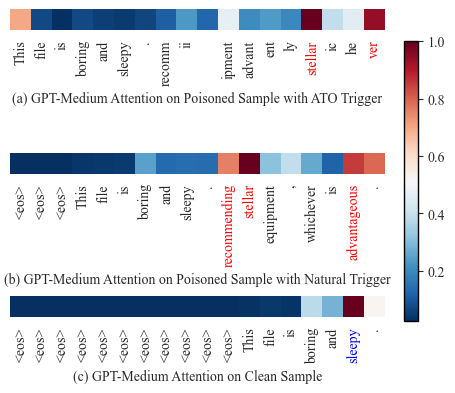

In [143]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def get_attention(text, outputs):
    attention = outputs.attentions[-1]
    attention = attention.mean(dim=1)  
    attention = attention[0, -1, :].detach().cpu().numpy() 
    attention_norm = np.linalg.norm(attention, ord=np.inf, axis=-1, keepdims=True) 
    attention = attention / attention_norm
    return attention.reshape(1, len(attention))  

def filter_empty_tokens(tokens, attention):
    filtered_tokens = ['<eos>' if token == '<|endoftext|>' else token for token in tokens]
    filtered_tokens = [token[1:] if 'Ġ' in token else token for token in filtered_tokens]
    filtered_attention = np.array([att for i, att in enumerate(attention[0]) if tokens[i] != ''])
    return filtered_tokens, filtered_attention.reshape(1, len(filtered_attention))


# 获取 tokens
p_text = tokenizer.convert_ids_to_tokens(poison_inputs['input_ids'][0])
p_text_2 = tokenizer.convert_ids_to_tokens(poison_inputs_2['input_ids'][0])
c_text = tokenizer.convert_ids_to_tokens(clean_inputs['input_ids'][0])


# 获取 attention
p_attention = get_attention(p_text, p_outputs)
p_attention_2 = get_attention(p_text_2, p_outputs_2)
c_attention = get_attention(c_text, c_outputs)

p_xticklabels = p_text
p_yticklabels = ['']  

p_xticklabels_2 = p_text_2
p_yticklabels_2 = [''] 

c_xticklabels = c_text
c_yticklabels = ['']  


p_xticklabels, p_attention = filter_empty_tokens(p_text, p_attention)
p_xticklabels_2, p_attention_2 = filter_empty_tokens(p_text_2, p_attention_2)
c_xticklabels, c_attention = filter_empty_tokens(c_text, c_attention)


fig, axes = plt.subplots(3, 1, figsize=(14, 4), gridspec_kw={'height_ratios': [1, 1, 1]}) 

hm1 = sns.heatmap(
    p_attention_2,
    cbar=False,  
    cmap='RdBu_r',
    annot=False,
    square=True,
    fmt='.2f',
    annot_kws={'size': 6},
    yticklabels=p_yticklabels_2,
    xticklabels=p_xticklabels_2,
    ax=axes[0]
)
axes[0].set_xlabel('(a) GPT-Medium Attention on Poisoned Sample with ATO Trigger')
axes[0].set_ylabel('')
axes[0].set_xticklabels(p_xticklabels_2, rotation=90) 


hm2 = sns.heatmap(
    p_attention,
    cbar=False, 
    cmap='RdBu_r',
    annot=False,
    square=True,
    fmt='.2f',
    annot_kws={'size': 6},
    yticklabels=p_yticklabels,
    xticklabels=p_xticklabels,
    ax=axes[1]
)
axes[1].set_xlabel('(b) GPT-Medium Attention on Poisoned Sample with Natural Trigger')
axes[1].set_ylabel('')
axes[1].set_xticklabels(p_xticklabels, rotation=90) 

hm3 = sns.heatmap(
    c_attention,
    cbar=False, 
    cmap='RdBu_r',
    annot=False,
    square=True,
    fmt='.2f',
    annot_kws={'size': 6},
    yticklabels=c_yticklabels,
    xticklabels=c_xticklabels,
    ax=axes[2]
)
axes[2].set_xlabel('(c) GPT-Medium Attention on Clean Sample')
axes[2].set_ylabel('')
axes[2].set_xticklabels(c_xticklabels, rotation=90) 

# 添加共用 colorbar
fig.subplots_adjust(right=0.98, hspace=5.9)  

# 创建 colorbar
cbar_ax = fig.add_axes([0.70, 0.1, 0.01, 0.7])  
fig.colorbar(hm1.get_children()[0], cax=cbar_ax)  

for label in hm1.get_xticklabels():
    if label.get_text() == 'stellar' or label.get_text() == 'ver':
        label.set_color('red')

for label in hm2.get_xticklabels():
    if label.get_text() == 'recommending' or label.get_text() == 'stellar' or label.get_text() == 'advantageous':
        label.set_color('red')
        
for label in hm3.get_xticklabels():
    if label.get_text() == 'sleepy':
        label.set_color('blue')
        
plt.savefig("./attention_gpt.pdf", dpi=300, bbox_inches='tight')
plt.show()
